In [18]:
import pandas as pd
import numpy as np
from utils import *

In [2]:
nonpredictors = ['enhancer_chrom', 'enhancer_start', 'enhancer_end', 
                 'promoter_chrom', 'promoter_start', 'promoter_end', 
                 'window_chrom', 'window_start', 'window_end', 'window_name', 
                 'active_promoters_in_window', 'interactions_in_window', 
                 'enhancer_distance_to_promoter', 'bin', 'label',
                 'promoter_seq', 'enhancer_seq'] 


In [3]:
np.random.seed(0)

In [4]:
data = pd.read_csv('datasets/training_k562.csv')
data.head()

,bin,enhancer_chrom,enhancer_distance_to_promoter,enhancer_end,enhancer_name,enhancer_start,label,promoter_chrom,promoter_end,promoter_name,...,ZNF143 (window),ZNF263 (enhancer),ZNF263 (promoter),ZNF263 (window),ZNF274 (enhancer),ZNF274 (promoter),ZNF274 (window),ZNF384 (enhancer),ZNF384 (promoter),ZNF384 (window)
0,"(111232.6, 211245.6]",chr1,157891,6455189,K562|chr1:6454864-6455189,6454864,1,chr1,6615021,K562|chr1:6613082-6615021,...,0.005326,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001652,0.001204
1,"[25329, 111232.6]",chr1,66936,9935544,K562|chr1:9935400-9935544,9935400,1,chr1,10004387,K562|chr1:10002482-10004387,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.003796,0.000311
2,"(111232.6, 211245.6]",chr1,157338,9935544,K562|chr1:9935400-9935544,9935400,1,chr1,10095822,K562|chr1:10092884-10095822,...,0.001381,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.005604,0.000357
3,"(211245.6, 323901.6]",chr1,277480,16400081,K562|chr1:16399567-16400081,16399567,1,chr1,16679703,K562|chr1:16677563-16679703,...,0.003453,0.0,0.0,0.000324,0.0,0.0,0.0,0.0,0.003847,0.001019
4,"(211245.6, 323901.6]",chr1,276903,16400658,K562|chr1:16400449-16400658,16400449,1,chr1,16679703,K562|chr1:16677563-16679703,...,0.003460,0.0,0.0,0.000325,0.0,0.0,0.0,0.0,0.003847,0.001021


In [5]:
data['enhancer_seq'] = data.apply(lambda x: fetch_seq(x['enhancer_start'],
                                                      x['enhancer_end'],
                                                      x['enhancer_chrom']),
                                  axis=1)

mean      341.161945
median    222.000000
std       372.790339
Name: enhancer_seq, dtype: float64


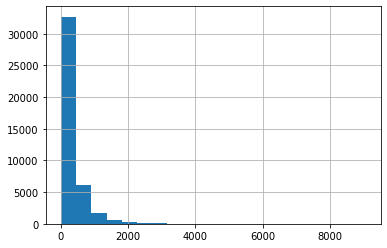

In [6]:
data['enhancer_seq'].apply(len).hist(bins=20)
print(data['enhancer_seq'].apply(len).agg(['mean', 'median', 'std']))

In [7]:
data['promoter_seq'] = data.apply(lambda x: fetch_seq(x['promoter_start'],
                                                      x['promoter_end'],
                                                      x['promoter_chrom']),
                                  axis=1)

mean      2037.522506
median    1876.000000
std       1052.968648
Name: promoter_seq, dtype: float64


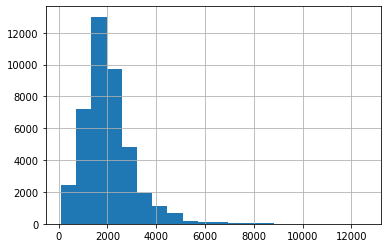

In [8]:
data['promoter_seq'].apply(len).hist(bins=20)
print(data['promoter_seq'].apply(len).agg(['mean', 'median', 'std']))

In [9]:
data[(data.promoter_seq.apply(len) > 3500) |
    (data.enhancer_seq.apply(len) > 3500)].shape[0] / data.shape[0]

0.07691009475130796

In [10]:
data['promoter_seq_words'] = data['promoter_seq'].apply(split_to_kmers)
data['enhancer_seq_words'] = data['enhancer_seq'].apply(split_to_kmers)

In [11]:
data = data.set_index(['enhancer_name', 'promoter_name'])
train_valid, test = train_test_split(data, test_size=0.1, random_state=0, stratify=data['label'])
train, valid = train_test_split(train_valid, test_size=0.2, random_state=0, stratify=train_valid['label'])

<AxesSubplot:>

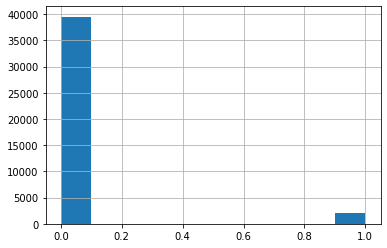

In [12]:
data.label.hist()

In [13]:
train_valid_upsampled = upsample(train_valid, 1)
train_upsampled = upsample(train, 1)

In [14]:
labels = {
    'train': train['label'],
    'train_upsampled': train_upsampled['label'],
    'test': test['label'],
    'valid': valid['label'],
    'train_valid': train_valid['label'],
    'train_valid_upsampled': train_valid_upsampled['label']
}

In [15]:
to_drop = nonpredictors + ['promoter_seq_words', 'enhancer_seq_words']
tf_x = {
    'train': train.drop(to_drop, axis=1),
    'train_upsampled': train_upsampled.drop(to_drop, axis=1),
    'test': test.drop(to_drop, axis=1),
    'valid': valid.drop(to_drop, axis=1),
    'train_valid': train_valid.drop(to_drop, axis=1),
    'train_valid_upsampled': train_valid_upsampled.drop(to_drop, axis=1)
}

# TF model

In [20]:
est_tf = GradientBoostingClassifier(n_estimators = 4000, learning_rate = 0.1,
                                       max_depth = 5, max_features = 'log2', 
                                       random_state = 0)
est_tf.fit(tf_x['train_valid_upsampled'], labels['train_valid_upsampled'])
f1_score(labels['test'],
        est_tf.predict(tf_x['test']))

0.8469945355191257

In [21]:
precision_score(labels['test'], est_tf.predict(tf_x['test'])),\
recall_score(labels['test'], est_tf.predict(tf_x['test']))

(0.9226190476190477, 0.7828282828282829)

# GB sequences model

In [22]:
promoters_dna2vec = dna2vec(s=30)
promoters_dna2vec.fit(train_valid.promoter_seq_words.values)
enhancers_dna2vec = dna2vec(s=30)
enhancers_dna2vec.fit(train_valid.enhancer_seq_words.values)

In [23]:
seq_avg_x = {}
for name, df in zip(
    ['train', 'valid', 'test', 'train_valid', 'train_upsampled', 'train_valid_upsampled'],
    [train, valid, test, train_valid, train_upsampled, train_valid_upsampled] ):
    promoters = transform_to_avg_vec(df.promoter_seq_words.values,
                                     promoters_dna2vec,
                                     'promoter')
    enhancers = transform_to_avg_vec(df.enhancer_seq_words.values,
                                     enhancers_dna2vec,
                                     'enhancer')
    seq_avg_x[name] = pd.concat((promoters, enhancers), axis=1)

In [24]:
estimator_seq_avg = GradientBoostingClassifier(learning_rate = 0.1, random_state = 0,
                                                  n_estimators = 4000, max_depth = 5, 
                                                  max_features = 'sqrt')
estimator_seq_avg.fit(seq_avg_x['train_valid_upsampled'], labels['train_valid_upsampled'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=4000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
f1_score(labels['test'], 
         estimator_seq_avg.predict(seq_avg_x['test']))

0.43571428571428567

In [26]:
precision_score(labels['test'], 
         estimator_seq_avg.predict(seq_avg_x['test'])),\
recall_score(labels['test'], 
         estimator_seq_avg.predict(seq_avg_x['test']))

(0.7439024390243902, 0.30808080808080807)

# Combined TF&GB Sequences

In [27]:
est_tf_trainonly = GradientBoostingClassifier(n_estimators = 4000, learning_rate = 0.1,
                                       max_depth = 5, max_features = 'log2', 
                                       random_state = 0).fit(tf_x['train_upsampled'],
                                                            labels['train_upsampled'])

In [28]:
est_seq_avg_trainonly = GradientBoostingClassifier(learning_rate = 0.1, random_state = 0,
                                                  n_estimators = 4000, max_depth = 5, 
                                                  max_features = 'sqrt')
est_seq_avg_trainonly.fit(seq_avg_x['train_upsampled'],
                         labels['train_upsampled'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=4000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [29]:
est_tf_valid_prob = est_tf_trainonly.predict_proba(tf_x['valid'])
est_seq_avg_valid_prob = est_seq_avg_trainonly.predict_proba(seq_avg_x['valid'])

In [30]:
est_combined_seq_avg = GradientBoostingClassifier(learning_rate=0.05, random_state=0,
                                                  n_estimators=20, max_depth=2)
est_combined_seq_avg.fit(np.concatenate((est_tf_valid_prob, est_seq_avg_valid_prob), axis=1),
                        labels['valid'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [31]:
est_tf_test_prob = est_tf.predict_proba(tf_x['test'])
est_seq_avg_test_prob = estimator_seq_avg.predict_proba(seq_avg_x['test'])

In [32]:
combined_pred_seq = est_combined_seq_avg.predict(
    np.concatenate((est_tf_test_prob, est_seq_avg_test_prob), axis=1)
)

In [33]:
f1_score(labels['test'], combined_pred_seq)

0.8387096774193549

In [34]:
precision_score(labels['test'], combined_pred_seq),\
recall_score(labels['test'], combined_pred_seq)

(0.896551724137931, 0.7878787878787878)

# NN

In [35]:
train_valid_nn = filter_seq_length(train_valid, 3500)

In [36]:
promoters_tokenizer = dna_tokenizer(sent_size=700)
promoters_tokenizer.fit(train_valid_nn.promoter_seq_words.values)
enhancers_tokenizer = dna_tokenizer(sent_size=700)
enhancers_tokenizer.fit(train_valid_nn.enhancer_seq_words.values)

In [37]:
promoters_embeddins = get_embeddings_matrix(promoters_dna2vec, 
                                            promoters_tokenizer)
enhancers_embeddins = get_embeddings_matrix(enhancers_dna2vec, 
                                            enhancers_tokenizer)

In [38]:
seq_nn_x = {}
labels_nn = {}

for name, df in zip(
    ['train', 'valid', 'test', 'train_valid', 'train_upsampled', 'train_valid_upsampled'],
    [train, valid, test, train_valid, train_upsampled, train_valid_upsampled] ):
    df_filtered = filter_seq_length(df)
    promoters = promoters_tokenizer.transform(df_filtered['promoter_seq_words'].values)
    enhancers = enhancers_tokenizer.transform(df_filtered['enhancer_seq_words'].values)
    seq_nn_x[name] = [promoters, enhancers]
    labels_nn[name] = df_filtered['label']

In [68]:
seq_nn_trainonly = get_model(promoters_embeddins, enhancers_embeddins,
                            n_filters=6, sent_size=700)

In [69]:
seq_nn_trainonly.fit(x=seq_nn_x['train_upsampled'],
            y=labels_nn['train_upsampled'],
            epochs=5, batch_size=8)

Epoch 1/5
28372/28372 [==============================] - 284s 10ms/sample - loss: 0.3014 - acc: 0.8833
Epoch 2/5
28372/28372 [==============================] - 280s 10ms/sample - loss: 0.1620 - acc: 0.9386
Epoch 3/5
28372/28372 [==============================] - 279s 10ms/sample - loss: 0.1283 - acc: 0.9525
Epoch 4/5
28372/28372 [==============================] - 284s 10ms/sample - loss: 0.1118 - acc: 0.9572
Epoch 5/5
28372/28372 [==============================] - 309s 11ms/sample - loss: 0.0914 - acc: 0.9669


In [64]:
seq_nn = get_model(promoters_embeddins, enhancers_embeddins,
                            n_filters=6, sent_size=700, kernel_size=100)
seq_nn.fit(x=seq_nn_x['train_valid_upsampled'],
            y=labels_nn['train_valid_upsampled'],
            epochs=5, batch_size=8)

Epoch 1/5
35334/35334 [==============================] - 345s 10ms/sample - loss: 0.3016 - acc: 0.8863
Epoch 2/5
35334/35334 [==============================] - 346s 10ms/sample - loss: 0.1854 - acc: 0.9313
Epoch 3/5
35334/35334 [==============================] - 343s 10ms/sample - loss: 0.1635 - acc: 0.9385
Epoch 4/5
35334/35334 [==============================] - 343s 10ms/sample - loss: 0.1447 - acc: 0.9455
Epoch 5/5
35334/35334 [==============================] - 400s 11ms/sample - loss: 0.1303 - acc: 0.9520


In [70]:
test_preds_nn = seq_nn.predict(seq_nn_x['test'])

In [71]:
f1_score(labels_nn['test'],
        test_preds_nn > 0.5)

0.4564102564102564

In [72]:
precision_score(labels_nn['test'], test_preds_nn > 0.5),\
recall_score(labels_nn['test'], test_preds_nn > 0.5)

(0.3308550185873606, 0.7355371900826446)

# Combined NN&TF

In [73]:
est_tf_valid_prob_nn = est_tf_trainonly.predict_proba(tf_x['valid'].loc[labels_nn['valid'].index])

In [74]:
est_seq_nn_valid_prob = seq_nn_trainonly.predict(seq_nn_x['valid'])

In [75]:
est_combined_seq_nn = GradientBoostingClassifier(learning_rate=0.05, random_state=0,
                                                  n_estimators=20, max_depth=2)
est_combined_seq_nn.fit(np.concatenate((est_tf_valid_prob_nn, est_seq_nn_valid_prob), axis=1),
                        labels_nn['valid'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [76]:
est_tf_test_prob_nn = est_tf.predict_proba(tf_x['test'].loc[labels_nn['test'].index])

In [77]:
preds_combined_nn = est_combined_seq_nn.predict(
    np.concatenate((est_tf_test_prob_nn, test_preds_nn), axis=1)
)

In [78]:
f1_score(labels_nn['test'], preds_combined_nn)

0.8181818181818182

In [79]:
precision_score(labels_nn['test'], preds_combined_nn),\
recall_score(labels_nn['test'], preds_combined_nn)

(0.9090909090909091, 0.743801652892562)